In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral

import dataclasses

In [4]:
%%time 

# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid) #time step → ▲t 

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing 
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.NavierStokes2D(viscosity, grid, smooth=smooth), dt)

# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: total: 4.06 s
Wall time: 2.62 s


## Decaying Turbulence

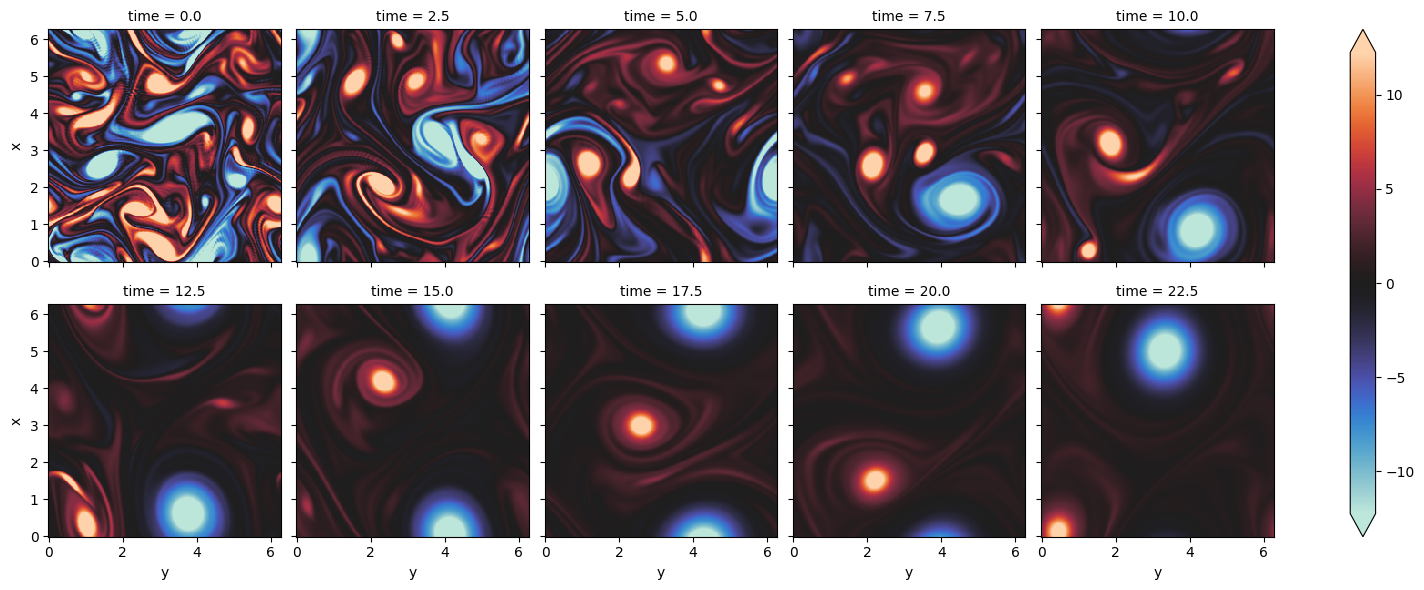

In [5]:

# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);
     

## Lid driven cavity

In [12]:
%%time

# physical parameter
viscosity = 1e-3
max_velocity = 7.0
density = 1
seed = 42
inner_steps = 25
outer_steps = 200
cfl_safety_factor = 0.5

# define the grid
grid = grids.Grid((256, 256), domain = ((0, 2 * jnp.pi), (0, 2 * jnp.pi))) # Grid 256 x 256 with (0, 2π) x (0, 2π)

''' construct a random initial velocity. The 'filtered_velocity_field' function in this https://github.com/google/jax-cfd/blob/main/jax_cfd/base/initial_conditions.py
    → ensure ▼u = 0 is filters out by high frequency fluctuations
'''
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(seed = seed), grid = grid, maximum_velocity = max_velocity)

# choose a time step.
dt = cfd.equations.stable_time_step(max_velocity = max_velocity, max_courant_number = cfl_safety_factor, viscosity = viscosity, grid = grid)

CPU times: total: 359 ms
Wall time: 102 ms
